In [3]:
PATH_TO_TRAIN_DATA = 'train.csv'
PATH_TO_TEST_DATA = 'test.csv'

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv(PATH_TO_TRAIN_DATA)

In [ ]:
alltest = pd.read_csv(PATH_TO_TEST_DATA)

In [8]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [10]:
alltest['negative'] = alltest['negative'].apply(process_text)
alltest['positive'] = alltest['positive'].apply(process_text)

In [11]:
def sent(x):
    return str(x).replace('[', '').replace(']', '').replace(', ', ' ').replace("'", '')

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=1412)

# Transformer:

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import transformers as ts
import datasets
from datasets import Dataset

In [ ]:
def get_target(df):
    return df[['positive', 'negative']], df['score']
x_test_all = alltest[['positive', 'negative']]

In [ ]:
x_test_all= x_test_all['positive'] + x_test_all['negative']

In [ ]:
df_train_all, df_val = train_test_split(df, random_state=1412, test_size = 0.01)

In [ ]:
x_train_all, y_train_all = get_target(df_train_all)

In [ ]:
x_train_all = x_train_all['positive'] + x_train_all['negative']

In [ ]:
x_val, y_val = get_target(df_val)

In [ ]:
x_val= x_val['positive'] + x_val['negative']

In [ ]:
import pyarrow as pa

In [ ]:
dataset_train = {}
dataset_train['sentence'] = x_train_all.apply(sent)
dataset_train['label'] = ((y_train_all - 1) * 10).astype(int)
dataset_train = Dataset(pa.Table.from_pydict(dataset_train))
dataset_train

Dataset({
    features: ['sentence', 'label'],
    num_rows: 99000
})

In [ ]:
dataset_val = {}
dataset_val['sentence'] = x_val.apply(sent)
dataset_val['label'] = ((y_val - 1) * 10).astype(int)
dataset_val = Dataset(pa.Table.from_pydict(dataset_val))
dataset_val

Dataset({
    features: ['sentence', 'label'],
    num_rows: 1000
})

In [ ]:
dataset_test = {}
dataset_test['sentence'] = x_test_all.apply(sent)
dataset_test = Dataset(pa.Table.from_pydict(dataset_test))
dataset_test

Dataset({
    features: ['sentence'],
    num_rows: 20000
})

In [ ]:
tokenizer = ts.AutoTokenizer.from_pretrained('distilbert-base-uncased', cache_dir='tmp1')
tokenizer

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at tmp1/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at tmp1/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a16963

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
def tokenizing_fn(instance):
    return tokenizer(instance['sentence'], truncation=True)

tokenized_test = dataset_test.map(tokenizing_fn)
tokenized_train = dataset_train.map(tokenizing_fn)
tokenized_val= dataset_val.map(tokenizing_fn)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
tokenized_val

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [ ]:
tokenized_train = tokenized_train.remove_columns(['sentence'])
tokenized_test = tokenized_test.remove_columns(['sentence'])
tokenized_val = tokenized_val.remove_columns(['sentence'])
tokenized_test

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 20000
})

In [ ]:
accuracy_metric = datasets.load_metric('accuracy', cache_dir='tmp/acc_metrics')
data_collator = ts.DataCollatorWithPadding(tokenizer = tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [ ]:
def compute_metrics(outputs):
    logits, labels = outputs
    preds = logits.argmax(1)

    metrics_dict = accuracy_metric.compute(
        references=labels, predictions=preds)

    return metrics_dict

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', cache_dir = 'tmp/model', num_labels =  100)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at tmp/model/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23

In [ ]:
training_args = ts.TrainingArguments(
    output_dir='tmp/model_output',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    weight_decay=1e-2,
    max_grad_norm=1.,
    warmup_ratio=0.1,
    metric_for_best_model='eval_loss',
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    report_to="wandb", 
    run_name="run_name"  
)
callbacks = [ts.EarlyStoppingCallback(3)]

PyTorch: setting up devices


In [ ]:
trainer = ts.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    callbacks=callbacks,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 99000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30940
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
1,2.319500,2.027878,0.277000
2,1.993000,2.010509,0.293000
3,1.870100,2.044888,0.292000
4,1.727100,2.175345,0.281000
5,1.595700,2.272457,0.268000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to tmp/model_output/checkpoint-6188
Configuration saved in tmp/model_output/checkpoint-6188/config.json
Model weights saved in tmp/model_output/checkpoint-6188/pytorch_model.bin
Deleting older checkpoint [tmp/model_output/checkpoint-12126] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to tmp/model_output/checkpoint-12376
Configuration saved in tmp/model_output/checkpoint-12376/config.json
Model weights saved in tmp/model_output/checkpoint-12376/pytorch_model.bin
Deleting older checkpoint [tmp/model_output/checkpoint-24252] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to tmp/model_output/checkpoint-18564
Configuration saved in tmp/model_output/checkpoint-18564/config.json
Model weights saved in tmp/model_output/checkpoint-18564/pytorch_mod

TrainOutput(global_step=30940, training_loss=1.9010752287693924, metrics={'train_runtime': 6378.2355, 'train_samples_per_second': 77.608, 'train_steps_per_second': 4.851, 'total_flos': 1.753106458410816e+16, 'train_loss': 1.9010752287693924, 'epoch': 5.0})

In [ ]:
predictions = trainer.predict(tokenized_test)

***** Running Prediction *****
  Num examples = 20000
  Batch size = 32


In [ ]:
predict = (np.argmax(predictions.predictions, axis=-1) / 10) + 1 

In [ ]:
answer = pd.DataFrame()
answer['review_id'] = alltest['review_id']
answer['score'] = predict
answer = answer.reset_index(drop=True)
answer.to_csv('3.4.csv', index=False)

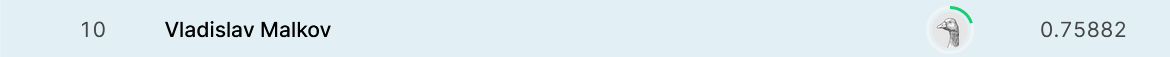

In [ ]:
from IPython.display import Image
Image("3.png")

# Линейная регрессия на TF-IDF векторах текстов:

### Обучимся и протестируем локально:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

In [14]:
def get_target(df):
    return df[['positive', 'negative']], df['score']

In [15]:
x_test_local, y_test_local = get_target(df_test)
x_train_local, y_train_local = get_target(df_train)

In [12]:
from scipy.sparse import hstack
vectorizer = TfidfVectorizer()
tfidf_train0 = vectorizer.fit_transform(x_train_local.iloc[:, 0].apply(sent))
tfidf_test0 = vectorizer.transform(x_test_local.iloc[:, 0].apply(sent))
tfidf_train1 = vectorizer.fit_transform(x_train_local.iloc[:, 1].apply(sent))
tfidf_test1 = vectorizer.transform(x_test_local.iloc[:, 1].apply(sent))
tfidf_train = hstack((tfidf_train0, tfidf_train1))
tfidf_test = hstack((tfidf_test0, tfidf_test1))

In [13]:
rid = Ridge().fit(tfidf_train, y_train_local)

In [14]:
y_pred_local = rid.predict(tfidf_test)
mean_absolute_error(y_test_local, y_pred_local)

0.8314118072933347

### Подготовим предикт для Kaggle:

In [ ]:
def get_target(df):
    return df[['positive', 'negative']], df['score']
x_train_all, y_train_all = get_target(df)
x_test_all = alltest[['positive', 'negative']]

In [ ]:
x_test_all = alltest[['positive', 'negative']]

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_train0 = vectorizer.fit_transform(x_train_all.iloc[:, 0].apply(sent))
tfidf_test0 = vectorizer.transform(x_test_all.iloc[:, 0].apply(sent))
tfidf_train1 = vectorizer.fit_transform(x_train_all.iloc[:, 1].apply(sent))
tfidf_test1 = vectorizer.transform(x_test_all.iloc[:, 1].apply(sent))
tfidf_train = hstack((tfidf_train0, tfidf_train1))
tfidf_test = hstack((tfidf_test0, tfidf_test1))

In [ ]:
rid = Ridge().fit(tfidf_train, y_train_all)

In [ ]:
y_pred_all = rid.predict(tfidf_test)

In [ ]:
answer = pd.DataFrame()
answer['review_id'] = alltest['review_id']
answer['score'] = y_pred_all
answer = answer.reset_index(drop=True)
answer.to_csv('1.csv', index=False)

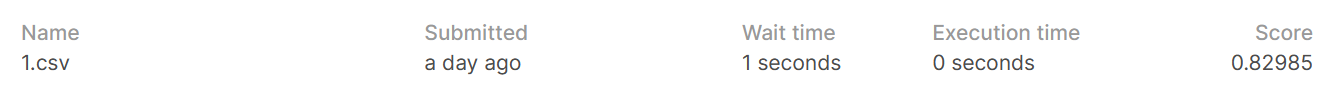

In [ ]:
from IPython.display import Image
Image("1.png")

# Score 0.82985:

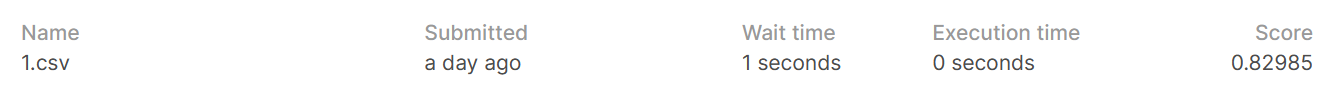

In [ ]:
from IPython.display import Image
Image("1.png")

# Линейная регрессия на Word2Vec векторах:

### Локально:

In [16]:
def sent(x):
    return str(x).replace('[', '').replace(']', '').replace(', ', ' ').replace("'", '')

In [17]:
x_test_local, y_test_local = get_target(df_test)
x_train_local, y_train_local = get_target(df_train)

In [18]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm.notebook import tqdm_notebook
import multiprocessing
import gensim.downloader as api
corpus = api.load('text8')

In [19]:
data = (x_test_local['positive'] +
        x_test_local['negative']).append(x_train_local['positive'] + x_train_local['negative'])

In [37]:
def calc_vect(model, corp):
    vect = []
    for senten in corp:
        if len(senten) != 0:
            vect.append((sum([model.wv.get_vector(word) for word in senten]) / len(senten)).tolist())
        else:
            vect.append([0] * model.vector_size)
    return vect

In [38]:
 def w2v(size1):
    model = Word2Vec(corpus, min_count=1, vector_size=size1)
    model.build_vocab(data, update=True)
    model.train(data, epochs=35, total_examples=model.corpus_count)
    vect1 = calc_vect(model, x_test_local['positive'])
    vect2 = calc_vect(model, x_test_local['negative'])
    vect3 = calc_vect(model, x_train_local['negative'])
    vect4 = calc_vect(model, x_train_local['positive'])
    reg = Ridge().fit((np.concatenate((pd.DataFrame(vect4),
                                               pd.DataFrame(vect3)), axis=1)), y_train_local)
    return vect1, vect2, reg 

**Размер эмбеддинга 300:**

In [39]:
vect1, vect2, reg = w2v(300)

In [40]:
y_pred_local1 = reg.predict((np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))
mean_absolute_error(y_test_local, y_pred_local1)

0.9312266364785554

**Размер эмбеддинга 600:**

In [ ]:
vect1, vect2, reg = w2v(600)

In [ ]:
y_pred_local1 = reg.predict((np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))
mean_absolute_error(y_test_local, y_pred_local1)

0.9217005157964833

### Сделаем предикт с размером эмбеддинга 600 для Kaggle:

In [ ]:
data_all = (x_test_all['positive'] +
        x_test_all['negative'])

In [ ]:
model = Word2Vec(corpus, min_count=1, size=600)
model.build_vocab(data, update=True)
model.train(data, epochs=35, total_examples=model.corpus_count)
model.build_vocab(data_all, update=True)
model.train(data_all, epochs=35, total_examples=model.corpus_count)

(16937857, 24224690)

In [ ]:
vect1 = []
vect1 = calc_vect(model, x_test_all['positive'])
vect2 = calc_vect(model, x_test_all['negative'])
vect3 = calc_vect(model, x_train_all['negative'])
vect4 = calc_vect(model, x_train_all['positive'])

In [ ]:
reg = Ridge().fit((np.concatenate((pd.DataFrame(vect4),
                                               pd.DataFrame(vect3)), axis=1)), y_train_all)
y_pred_all = reg.predict((np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))

In [ ]:
answer = pd.DataFrame()
answer['review_id'] = alltest['review_id']
answer['score'] = y_pred_all
answer = answer.reset_index(drop=True)
answer.to_csv('2.1.csv', index=False)

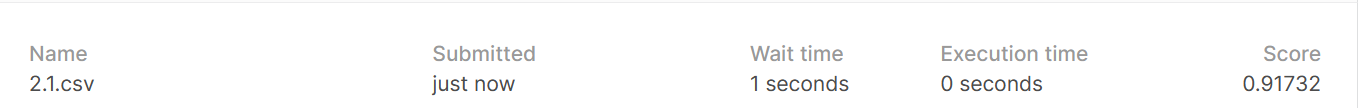

In [ ]:
from IPython.display import Image
Image("2.png")

Перевзвесим векторы слов при помощи IDF:

In [41]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(data.apply(sent))

<100000x34692 sparse matrix of type '<class 'numpy.float64'>'
	with 2631452 stored elements in Compressed Sparse Row format>

In [42]:
def calc_vect_idf(model, corp, idf):
    vect = []
    for senten in corp:
        if len(senten) != 0:
            vect.append((sum([model.wv.get_vector(word)* 
                           idf.get(word, 1) for word in senten]) / len(senten)).tolist())
        else:
            vect.append([0] * model.vector_size)
    return vect

In [43]:
idf = {}
for i in vectorizer.vocabulary_:
    idf[i] = vectorizer.idf_[vectorizer.vocabulary_[i]]

In [44]:
model = Word2Vec(corpus, min_count=1, vector_size=300)
model.build_vocab(data, update=True)
model.train(data, epochs=35, total_examples=model.corpus_count)

(84241950, 120424360)

In [45]:
vect1 = calc_vect_idf(model, x_test_local['positive'], idf)
vect2 = calc_vect_idf(model, x_test_local['negative'], idf)
vect3 = calc_vect_idf(model, x_train_local['negative'], idf)
vect4 = calc_vect_idf(model, x_train_local['positive'], idf)

In [46]:
rid = Ridge().fit(pd.DataFrame(np.concatenate((pd.DataFrame(vect3),
                                               pd.DataFrame(vect4)), axis=1)), y_train_local)
y_pred_local = rid.predict(pd.DataFrame(np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))
mean_absolute_error(y_test_local, y_pred_local)

1.5407418447579717

In [25]:
mae = []
for size in tqdm_notebook(range(1, 400, 40)):
  vect1, vect2, reg = w2v(size)
  y_pred_local1 = reg.predict((np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))
  mae.append(mean_absolute_error(y_test_local, y_pred_local1))

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'График зависимости качества модели от размерности эмбеддинга')

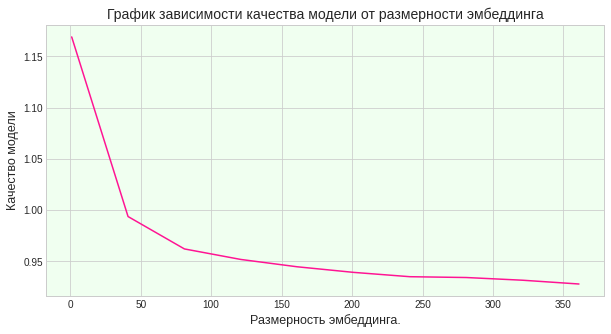

In [29]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("honeydew")
plt.plot(np.arange(1, 400, 40) ,mae , c='deeppink')
plt.xlabel('Размерность эмбеддинга.', fontsize=12.5)
plt.ylabel('Качество модели', fontsize=12.5)
plt.title('График зависимости качества модели от размерности эмбеддинга', fontsize=14)

#### Выводы:
Было рассмотрено 3 тактики строить Word2vec:

1. Строить отдельные модели для каждого из датасетов (итого 4 модели для *`Train positive`*, *`Test positive`*, *`Train negative`*, *`Test negative`*)

2. Строить одну модель, при этом положительные и отрицательные отзывы являются разными каталогами(предложениями)

3. Строить одну модель, при этом склеить положительные и отрицательные отзывы в один каталог(предложение)

При выполнении задания я выбрал 3 тактику экспериментальным путем. 

При использовании 1 тактики предложения получались небольшими и корпус оказывался небольшим. Таким образом при увеличении размерности эмбеддинга качество не расло, ведь слов немного и поэтому большое количество координат векторов не давало пользы.

При 2 и 3 тактике же увеличение размеров эмбеддинга давало мощный прирост качества в силу большого размера корпуса.

3 тактика показывала лучшие результаты, ведь каталоги(предложения) имели большую длину, а следовательно у большего числа слов есть соседи при помощи которых модель лучше понимает смысл.

При использовании в качестве весов `IDF` качество упало. 

Для 2 тактики `IDF` мог дать прирост в силу устройства каталогов, но для 3 уже портил качество. Например слово _"no"_ или _"not"_ могло встречаться как в положительных, так и в отрицательных отзывах, а слова _"good"_ или _"bad"_ уже чаще всего присуще определенному типу, что создавло путаницу при перевзвешивании слов в склеенных отзывах.
Имеено поэтому в первом номере использовалась 1 тактика про построении `TF-IDF` векторов текстов.

`FastText` дал не очень хороший результат. В силу составления символьных n-грамм моделью она работает очень долго. Ошибка получилась большой, ведь модель хорошо работает на редких и устаревших словах, что не очень полезно в нашей задаче.

### В качестве других эмбеддингов размерности 300 используем FastText:

In [48]:
from gensim.models import FastText

In [49]:
model = FastText(corpus, min_count=1, vector_size=300)
model.build_vocab([row.split() for row in data.apply(sent)], update=True)
model.train([row.split() for row in data.apply(sent)], epochs=35, total_examples=model.corpus_count)

(84248613, 120424360)

In [50]:
vect1 = calc_vect(model, x_test_local['positive'])
vect2 = calc_vect(model, x_test_local['negative'])
vect3 = calc_vect(model, x_train_local['negative'])
vect4 = calc_vect(model, x_train_local['positive'])

In [51]:
rid = Ridge().fit(pd.DataFrame(np.concatenate((pd.DataFrame(vect3),
                                               pd.DataFrame(vect4)), axis=1)), y_train_local)
y_pred_local = rid.predict(pd.DataFrame(np.concatenate((pd.DataFrame(vect1), pd.DataFrame(vect2)), axis=1)))
mean_absolute_error(y_test_local, y_pred_local)

1.6253479121982854

# Score 0.91732:

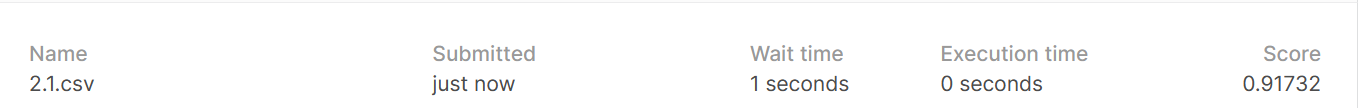

In [ ]:
from IPython.display import Image
Image("2.png")